# Persistence Entropy for dgms

- shannon entropy but for persistence diagrams
- shuffled vs real data dgms

@emilyekstrum
<br> 11/17/25

In [ ]:
import os
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from persim.persistent_entropy import persistent_entropy
import statistics 
import pandas as pd
import seaborn as sns
from scipy import stats

In [ ]:
# define stimuli and load in data from file path to directory with pkl dgms files
# example input file names in file path: CEBRA_3d_LGN_cex_C153.pkl or LGN_3d_shuffled_drifting gratings_C159.pkl

stimuli = ["cex", "color_exchange", "dg", "drifting_gratings", "cg", "chromatic_gratings", "lf", "luminance_flash"]

LGN_path = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\24d\LGN" # directory should contain pkl files with real and shuffled dgms if you want to use downstream analysis code

files = glob.glob(os.path.join(LGN_path, "*.pkl"))


In [ ]:
# mapping between abbreviations and full stimulus names
stimulus_mapping = {
    "cex": "color_exchange",
    "color_exchange": "color_exchange",
    "cg": "chromatic_gratings", 
    "chromatic_gratings": "chromatic_gratings",
    "lf": "luminance_flash",
    "luminance_flash": "luminance_flash",
    "dg": "drifting_gratings",
    "drifting_gratings": "drifting_gratings"
}

# Group files by both shuffling status and stimulus type
groups = {}

for file in files:
    filename = os.path.basename(file).lower()
    is_shuffled = "shuffled" in filename
    
    stimulus_type = None
    for stimulus in stimulus_mapping.keys():
        if stimulus in filename:
            stimulus_type = stimulus_mapping[stimulus]
            break
    
    if stimulus_type is None:
        print(f"Warning: Could not identify stimulus type for file: {filename}")
        continue
    
    group_key = f"{stimulus_type}_{'shuffled' if is_shuffled else 'unshuffled'}"
    
    if group_key not in groups:
        groups[group_key] = []
    groups[group_key].append(file)

# check you have the right files grouped by stimulus and shuffling status
print("Files:")
for group, file_list in groups.items():
    print(f"{group}: {len(file_list)} files")


Files:
color_exchange_unshuffled: 2 files
chromatic_gratings_unshuffled: 1 files
drifting_gratings_unshuffled: 1 files
luminance_flash_unshuffled: 2 files
chromatic_gratings_shuffled: 1 files
color_exchange_shuffled: 2 files
drifting_gratings_shuffled: 1 files
luminance_flash_shuffled: 2 files


In [ ]:
# calculate PE for each group 

# Dictionary to store PE values organized by stimulus and shuffling status
pe_data = {
    'stimulus': [],
    'shuffling_status': [],
    'h0_pe': [],
    'h1_pe': [],
    'h2_pe': []
}

# Calculate PE for each group
for group_key, file_list in groups.items():
    if len(file_list) == 0:
        continue
        
    parts = group_key.split('_')
    shuffling_status = parts[-1]  # 'shuffled' or 'unshuffled'
    stimulus = '_'.join(parts[:-1])  # stimulus name
    
    print(f"Processing {group_key}: {len(file_list)} files")
    
    # PE for all files 
    for file in file_list:
        try:
            with open(file, 'rb') as f:
                dgms = pkl.load(f)
            h0_PE, h1_PE, h2_PE = persistent_entropy(dgms)
            
            pe_data['stimulus'].append(stimulus)
            pe_data['shuffling_status'].append(shuffling_status)
            pe_data['h0_pe'].append(h0_PE)
            pe_data['h1_pe'].append(h1_PE)
            pe_data['h2_pe'].append(h2_PE)
            
        except Exception as e:
            print(f"Error processing file {file}: {e}")

df = pd.DataFrame(pe_data)

# Calculate summary statistics
summary_stats = df.groupby(['stimulus', 'shuffling_status']).agg({
    'h0_pe': ['mean', 'std', 'count'],
    'h1_pe': ['mean', 'std', 'count'], 
    'h2_pe': ['mean', 'std', 'count']
}).round(4)

# summary table
print("\nSummary Statistics:")
print(summary_stats)


Processing color_exchange_unshuffled: 2 files
Processing chromatic_gratings_unshuffled: 1 files
Processing drifting_gratings_unshuffled: 1 files
Processing luminance_flash_unshuffled: 2 files
Processing chromatic_gratings_shuffled: 1 files
Processing color_exchange_shuffled: 2 files
Processing drifting_gratings_shuffled: 1 files
Processing luminance_flash_shuffled: 2 files

Summary Statistics:
                                      h0_pe                  h1_pe          \
                                       mean     std count     mean     std   
stimulus           shuffling_status                                          
chromatic_gratings shuffled          9.2081     NaN     1  10.2818     NaN   
                   unshuffled        9.1645     NaN     1   8.8956     NaN   
color_exchange     shuffled          9.2009  0.0026     2   9.4068  0.1970   
                   unshuffled        9.0937  0.0291     2   7.4357  0.1261   
drifting_gratings  shuffled          9.2004     NaN     1

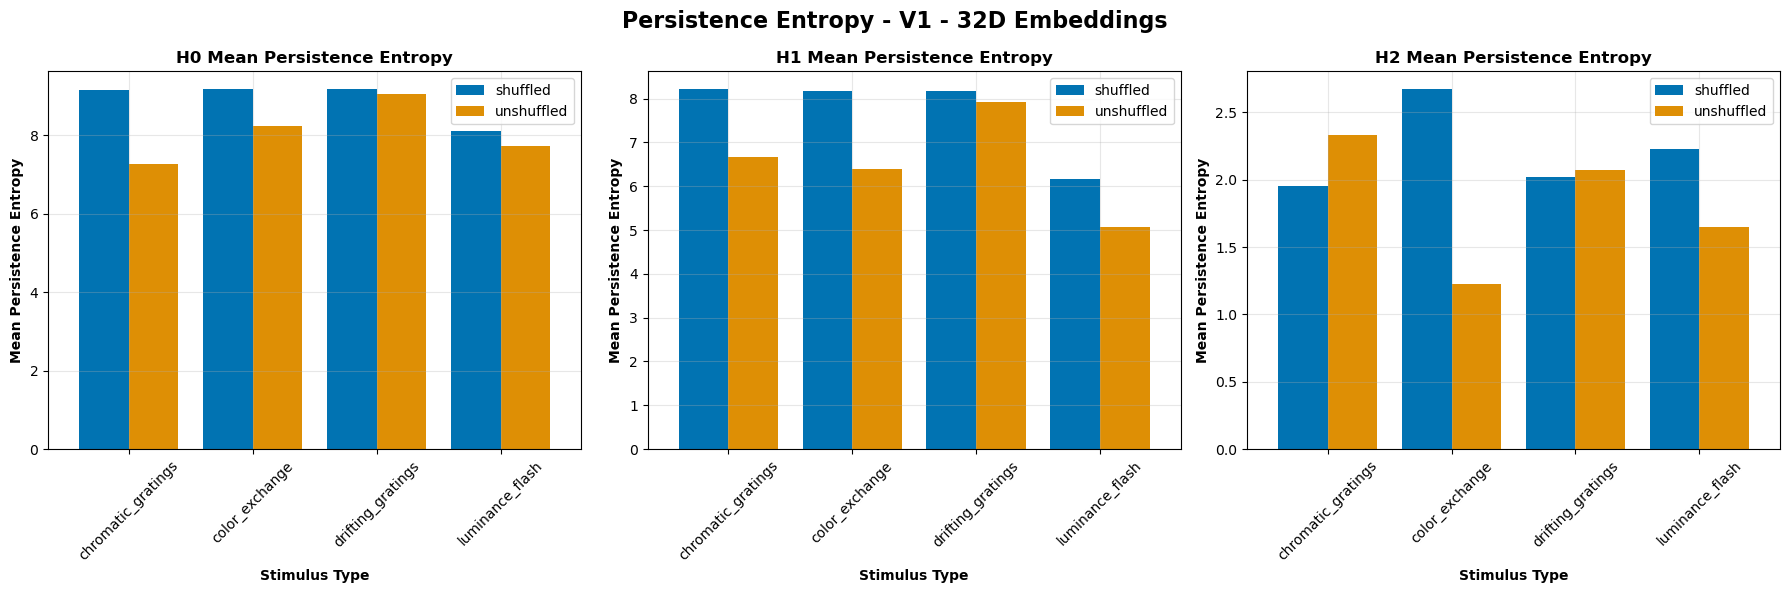


Comparison Table:
                   h0_pe                 h1_pe                 h2_pe          \
                   count    mean     std count    mean     std count    mean   
stimulus                                                                       
chromatic_gratings     2  8.2218  1.3322     2  7.4412  1.0921     2  2.1414   
color_exchange         4  8.7079  0.7271     4  7.2795  1.2236     4  1.9471   
drifting_gratings      2  9.1191  0.0780     2  8.0498  0.1765     2  2.0450   
luminance_flash        4  7.9127  0.2405     4  5.6192  0.6656     4  1.9399   

                            
                       std  
stimulus                    
chromatic_gratings  0.2702  
color_exchange      1.1515  
drifting_gratings   0.0371  
luminance_flash     0.3919  


In [ ]:
# generate plots for shuffled vs unshuffled PE values grouped by stimuli

plt.style.use('default')
sns.set_palette("colorblind")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Persistence Entropy - V1 - 32D Embeddings', fontsize=16, fontweight='bold')

homology_dims = ['h0_pe', 'h1_pe', 'h2_pe']
titles = ['H0 Persistence Entropy', 'H1 Persistence Entropy', 'H2 Persistence Entropy']

""" for i, (dim, title) in enumerate(zip(homology_dims, titles)):
    ax = axes[i]
    
    # box plot
    sns.boxplot(data=df, x='stimulus', y=dim, hue='shuffling_status', ax=ax)
    
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Stimulus Type', fontweight='bold')
    ax.set_ylabel('Persistence Entropy', fontweight='bold')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show() 

plt.figure(figsize=(15, 5))"""

mean_data = df.groupby(['stimulus', 'shuffling_status'])[['h0_pe', 'h1_pe', 'h2_pe']].mean().reset_index()

for i, (dim, title) in enumerate(zip(['h0_pe', 'h1_pe', 'h2_pe'], ['H0', 'H1', 'H2'])):
    plt.subplot(1, 3, i+1)

    pivot_data = mean_data.pivot(index='stimulus', columns='shuffling_status', values=dim)
    
    # grouped bar plot
    pivot_data.plot(kind='bar', ax=plt.gca(), width=0.8)
    
    plt.title(f'{title} Mean Persistence Entropy', fontweight='bold')
    plt.xlabel('Stimulus Type', fontweight='bold')
    plt.ylabel('Mean Persistence Entropy', fontweight='bold')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison Table:")
comparison_table = df.groupby(['stimulus']).agg({
    'h0_pe': ['count', 'mean', 'std'],
    'h1_pe': ['count', 'mean', 'std'],
    'h2_pe': ['count', 'mean', 'std']
}).round(4)

print(comparison_table)


In [ ]:
# compare shuffled vs unshuffled for each stimulus type

print("Shuffled vs Unshuffled Persistence Entropy")

# t-tests for each stimulus type and homology dimension
stimuli = df['stimulus'].unique()

for stimulus in stimuli:
    print(f"\nStimulus: {stimulus}")
    print("-" * 40)
    
    # Filter data for this stimulus
    stimulus_data = df[df['stimulus'] == stimulus]
    shuffled_data = stimulus_data[stimulus_data['shuffling_status'] == 'shuffled']
    unshuffled_data = stimulus_data[stimulus_data['shuffling_status'] == 'unshuffled']
    
    if len(shuffled_data) > 0 and len(unshuffled_data) > 0:
        for dim in ['h0_pe', 'h1_pe', 'h2_pe']:
            #  t-test
            t_stat, p_value = stats.ttest_ind(shuffled_data[dim], unshuffled_data[dim])
            
            # effect size (Cohen's d)
            pooled_std = np.sqrt(((len(shuffled_data)-1)*shuffled_data[dim].std()**2 + 
                                (len(unshuffled_data)-1)*unshuffled_data[dim].std()**2) / 
                               (len(shuffled_data) + len(unshuffled_data) - 2))
            cohens_d = (shuffled_data[dim].mean() - unshuffled_data[dim].mean()) / pooled_std
            
            # summary info
            print(f"{dim}:")
            print(f"  Shuffled:   n={len(shuffled_data):2d}, mean={shuffled_data[dim].mean():.4f}, std={shuffled_data[dim].std():.4f}")
            print(f"  Unshuffled: n={len(unshuffled_data):2d}, mean={unshuffled_data[dim].mean():.4f}, std={unshuffled_data[dim].std():.4f}")
            print(f"  t-test: t={t_stat:.4f}, p={p_value:.4f}, Cohen's d={cohens_d:.4f}")
            print(f"  Significance: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
            print()

#  summary heatmap of mean PE values
plt.figure(figsize=(12, 8))

# pivot table for heatmap
heatmap_data = df.groupby(['stimulus', 'shuffling_status'])[['h0_pe', 'h1_pe', 'h2_pe']].mean()

# Create separate heatmaps for each homology dimension
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Mean Persistence Entropy Heatmaps', fontsize=16, fontweight='bold')

for i, dim in enumerate(['h0_pe', 'h1_pe', 'h2_pe']):
    pivot_heatmap = heatmap_data[dim].unstack(level=1)
    
    #  heatmap
    sns.heatmap(pivot_heatmap, annot=True, fmt='.4f', cmap='viridis', 
                ax=axes[i], cbar_kws={'label': 'Mean PE'})
    
    axes[i].set_title(f'{dim.upper()} Persistence Entropy', fontweight='bold')
    axes[i].set_xlabel('Shuffling Status')
    axes[i].set_ylabel('Stimulus Type')

plt.tight_layout()
plt.show()


Statistical Analysis: Shuffled vs Unshuffled Persistence Entropy

Stimulus: color_exchange
----------------------------------------
h0_pe:
  Shuffled:   n= 2, mean=9.1735, std=0.0002
  Unshuffled: n= 2, mean=8.2424, std=0.8480
  t-test: t=1.5529, p=0.2606, Cohen's d=1.5529
  Significance: ns

h1_pe:
  Shuffled:   n= 2, mean=8.1691, std=0.0006
  Unshuffled: n= 2, mean=6.3900, std=1.1519
  t-test: t=2.1842, p=0.1606, Cohen's d=2.1842
  Significance: ns

h2_pe:
  Shuffled:   n= 2, mean=2.6719, std=0.0101
  Unshuffled: n= 2, mean=1.2223, std=1.3700
  t-test: t=1.4963, p=0.2732, Cohen's d=1.4963
  Significance: ns


Stimulus: chromatic_gratings
----------------------------------------


c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\scipy\stats\_stats_py.py:6195: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


ZeroDivisionError: float division by zero